This notebook explains how to get a first grid2op environment, then use the data it needs to generate some loads and renewables (and a shitty market design) and load this second environment.

In [2]:
import grid2op
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from grid2op.ChronicsHandler import ChangeNothing
from grid2op.PlotMatplotlib import GetLayout
print("This notebook uses the last dev version of grid2op. You can install it with:\n"\
      "\t{} -m pip install git+https://github.com/bdonnot/grid2op.git@betternotebooks --user".format(sys.executable))

#path_grid = os.path.join("data", "case118_l2rpn")

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
This notebook uses the last dev version of grid2op. You can install it with:
	/opt/local/Library/Frameworks/Python.framework/Versions/3.6/bin/python3.6 -m pip install git+https://github.com/bdonnot/grid2op.git@betternotebooks --user


In [2]:
# Chronix2grid modules
sys.path.insert(0, '..')
import generation.generate_chronics as gen
import generation.consumption.generate_load as gen_loads
import generation.renewable.generate_solar_wind as gen_enr
import generation.thermal.generate_dispatch as gen_dispatch

import generation.dispatch.EconomicDispatch as ec
import generation.thermal.EDispatch_L2RPN2020.run_economic_dispatch as run_economic_dispatch
import kpi.main as kpis

In [3]:
### CONSTANT

## Generation step of chronix2grid
INPUT_FOLDER = 'generation/input'
OUTPUT_FOLDER = 'generation/output'
CASE = 'case118_l2rpn'

start_date = "2012-01-01"
weeks = 52
n_scenarios = 1
    # Detailed configuration to set in <INPUT_FOLDER>/<CASE>/params.json


## KPI computation phase
KPI_INPUT_FOLDER = 'kpi/input'
IMAGES_FOLDER = 'kpi/images'
    # Detailed configuration to set in <KPI_INPUT_FOLDER>/params.json

# Load the environment

In [4]:
path_grid = os.path.join(INPUT_FOLDER, CASE)

env118_withoutchron = grid2op.make("blank",  # to generate a blank environment
                      grid_path=os.path.join(path_grid, "L2RPN_2020_case118_redesigned.json"), # assign it the 118 grid
                      chronics_class=ChangeNothing, # tell it to change nothing (not the most usable environment...)
                  )
grid_layout =  [(-403, -311), (-355, -311), (-380, -275), (-355, -245), (-369, -191), (-330, -193), (-299, -190), 
                (-366, -88),
         (-364, -44), (-366, -7), (-320, -247), (-266, -266), (-241, -198), (-203, -231), (-188, -201), (-282, -153),
         (-221, -123), (-161, -123), (-131, -156), (-139, -142), (-131, -27), (-123, -3), (-131, 29), (-18, -46),
         (-162, 67), (-203, 39), (-324, 21), (-332, -15), (-331, -52), (-212, -88), (-292, -52), (-259, -29),
         (-4, -254), (32, -203), (-34, -148), (51, -155), (74, -221), (88, -127), (59, -265), (86, -296), (129, -296),
         (161, -296), (124, -198), (140, -226), (147, -163), (133, -138), (162, -134), (187, -173), (221, -125),
         (268, -215), (287, -225), (199, -258), (202, -296), (237, -295), (329, -296), (283, -297), (268, -248),
         (287, -248), (372, -277), (372, -197), (372, -153), (340, -74), (348, -254), (342, -168), (298, -29),
         (283, -74), (297, -92), (213, -62), (184, -50), (61, -45), (40, -73), (25, -52), (61, -84), (43, 53), (61, 73),
         (151, 73), (176, 99), (195, 53), (221, 33), (227, 73), (230, 56), (149, 131), (57, 154), (46, 171), (43, 205),
         (43, 229), (57, 245), (78, 205), (119, 207), (122, 241), (191, 243), (196, 207), (219, 186), (245, 154),
         (212, 154), (221, 132), (220, 110), (262, 94), (294, 74), (288, 154), (273, 230), (226, 229), (326, 230),
         (330, 152), (365, 154), (364, 91), (404, 154), (370, 191), (373, 212), (361, 253), (330, 260), (403, 253),
(-256, -102), (-270, 0), (-236, 1), (229, -32), (-211, -266), (99, 74)]

# Check the Energy Mix apriori

In [5]:
%run kpi/Generator_parameter_checker.py
Target_EM_percentage=pd.DataFrame(data=[4,6,35,15,40],columns=['target_energy_mix'],
                                  index=['solar','wind','nuclear','hydro','thermal'])
PeakLoad=4200
AverageLoad=2800
CapacityFactor=pd.DataFrame(data=[15,25,95,30,np.nan],columns=['capacity_factor'],
                            index=['solar','wind','nuclear','hydro','thermal'])
Capacity_df=EnergyMix_AprioriChecker(env118_withoutchron,Target_EM_percentage, PeakLoad, AverageLoad, CapacityFactor )
Capacity_df

,target_energy_mix,pmax,capacity_mix,capacity_factor,Apriori_energy_mix,revised_pmax
solar,4,747.0,10.3,15.0,4.001786,746.666667
wind,6,672.0,9.3,25.0,6.000000,672.000000
nuclear,35,1031.7,14.3,95.0,35.004107,1031.578947
hydro,15,1618.0,22.4,30.0,17.335714,1400.000000
thermal,40,3168.5,43.8,NaN,37.658393,3168.421053


# II Generate the data

**You can set generation configuration such as number of scenarios, start date, number of weeks, noise intensities, timestep... in INPUT_FOLDER/CASE/params.json**

# II A) Generate loads and renewables

Chronix2grid generation process which implements Balthazar method. CSV writting takes long

In [6]:
## Reading parameters
year, params, loads_charac, prods_charac, load_weekly_pattern, solar_pattern, lines = gen.read_configuration(INPUT_FOLDER, CASE, start_date, weeks)
print(year)

## Whole generation
# gen.main(year, n_scenarios, params, INPUT_FOLDER, OUTPUT_FOLDER, prods_charac, loads_charac, lines, solar_pattern, load_weekly_pattern)


## OR ============

## Separate generation for load and renewables

# Create folders
dispatch_input_folder = os.path.join(INPUT_FOLDER, 'dispatch/' + str(year))
dispatch_output_folder = os.path.join(OUTPUT_FOLDER, str(year))

# Make sure the seeds are the same, whether computation is parallel or sequential
seeds = [np.random.randint(low=0, high=2**31) for _ in range(n_scenarios)]

# Make sure the output folders exist
main_folder = os.path.join(dispatch_input_folder)
if not os.path.exists(main_folder):
    os.mkdir(main_folder)

out_folder = os.path.join(dispatch_output_folder)
if not os.path.exists(out_folder):
    os.mkdir(out_folder)

# Launch load generation
for i, seed in enumerate(seeds):
    print("================ Generating scenario number "+str(i)+" ================")
    load, load_forecasted = gen_loads.main(i, dispatch_input_folder, seed, params, loads_charac, load_weekly_pattern, write_results = True)

    print('\n')

Importing parameters ...
Importing loads and prods parameters ...
2012
================ Generating scenario number 0 ================
Computing global auto-correlated spatio-temporal noise for thermosensible demand...
Computing loads ...
Saving files in zipped csv




## Check load hypothesis (peak and average)

**if this differs by too much, you should update the computation of the Energy Mix a priori and revise some calibration if not satisfactory**

In [7]:
CurrentPeakLoad=load.sum(axis=1).max()
print('the expected peak load was: '+str(PeakLoad))
print('the actual peak load is: '+str(CurrentPeakLoad))

the expected peak load was: 4200
the actual peak load is: 4023.2985357968732


In [8]:
CurrentAverageLoad=load.sum(axis=1).mean()
print('the expected average load was: '+str(AverageLoad))
print('the actual average load is: '+str(CurrentAverageLoad))

the expected average load was: 2800
the actual average load is: 2521.1324558049932


## Generate Renewables

In [9]:
# Launch solar and wind generation
for i, seed in enumerate(seeds):
    print("================ Generating scenario number "+str(i)+" ================")
    prod_solar, prod_solar_forecasted, prod_wind, prod_wind_forecasted = gen_enr.main(i, dispatch_input_folder, seed,params, prods_charac, solar_pattern, 
                                                                                      write_results = True)
    # Function that will be used when dispatch is ready
    # For now it only generates hazards and maintenance
    gen_dispatch.main(i, load, prod_solar, prod_wind, out_folder, seed, params,prods_charac, lines, compute_hazards = True)
    print('\n')

================ Generating scenario number 0 ================
Computing global auto-correlated spatio-temporal noise for sun and wind...
Generating solar and wind production chronics
Saving files in zipped csv
Generating maintenance and hazard signals ...




In [10]:
## Reading parameters
year, n_scenarios, params, loads_charac, prods_charac, load_weekly_pattern, solar_pattern, lines = gen.read_configuration(INPUT_FOLDER, CASE)
print(year)
gen.main(year, n_scenarios, params, INPUT_FOLDER, OUTPUT_FOLDER, prods_charac, loads_charac, lines, solar_pattern, load_weekly_pattern)

TypeError: read_configuration() missing 2 required positional arguments: 'start_date' and 'weeks'

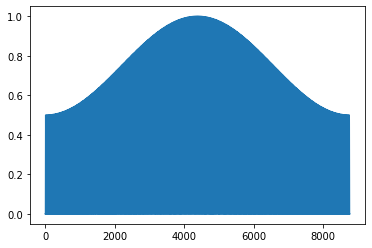

In [11]:
plt.plot(solar_pattern)

In [12]:
# It has been generated in this folder
chronics_path_gen = os.path.join(INPUT_FOLDER, "dispatch", str(year))

## Check Ramps and Pmin/Pmax Generator parameters A priori

### Select the scenario you want to check first

In [13]:
%run kpi/Generator_parameter_checker.py

losses_pct = 3.0  # losses as pct of load
[isThermalInTrouble,isNuclearInTrouble,IsRampUpInTrouble,IsRampDownInTrouble]=Ramps_Pmax_Pmin_APrioriCheckers(
    env118_withoutchron,Capacity_df,chronics_path_gen,losses_pct,PeakLoad)


 the wind share is 6.9
the wind share was expected to be 6
the solar share is 3.9
the solar share was expected to be 4

 the max load is 4144.308000000001
the expected peak load was 4200

 the max net load is 3831.471

 the min net load is 964.648
the nuclear capacity is 1031.6999999999998
the max net load decrease 84.40800000000036
the nuclear max ramp Down is 7.164583333333333
are we in trouble for nuclear:True

 the max net load ramp up is 84.40800000000036
the max generation ramp up is 160.16325242391596

 the max net load ramp down is -80.58100000000059
the max nuclear + hydro ramp down is 74.58125000000001


/Users/camiloromero/Rte/ChroniX2Grid/chronix2grid/kpi/Generator_parameter_checker.py:219: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [14]:
print(isThermalInTrouble)
print(isNuclearInTrouble)
print(IsRampUpInTrouble)
print(IsRampDownInTrouble)

False
True
False
False


In [15]:
%run kpi/Generator_parameter_checker.py
Aposteriori_renewableCapacityFactor_Checkers(env118_withoutchron,Capacity_df, chronics_path_gen)


 the max wind production 659.5

 the expected max wind production was 672.0000000000001

 the max solar production 510.8

 the expected max solar production was 747.0000000000001

 the solar capacity factor is: 0.13646101431632215

 the expected solar capacity factor was: 15.0

 the wind capacity factor is: 0.2682323755696685

 the expected wind capacity factor was: 25.0


[0.13646101431632215, 0.2682323755696685]

### Compute some KPIs for solar, wind and load

#### Good comparison can be obtained by setting "renewable_ninja" as comparison in KPI_INPUT_FOLDER/paramsKPI.json
Images are saved in IMAGES_FOLDER 

================================================= KPI GENERATION  ===================================================================
Scenario 0...
Importing and formatting data downloaded from Renewable Ninja API
 Formatting chronics for KPI
Year 2012
(1) Computing KPI's...
(2) Generating json output file...
-Done-



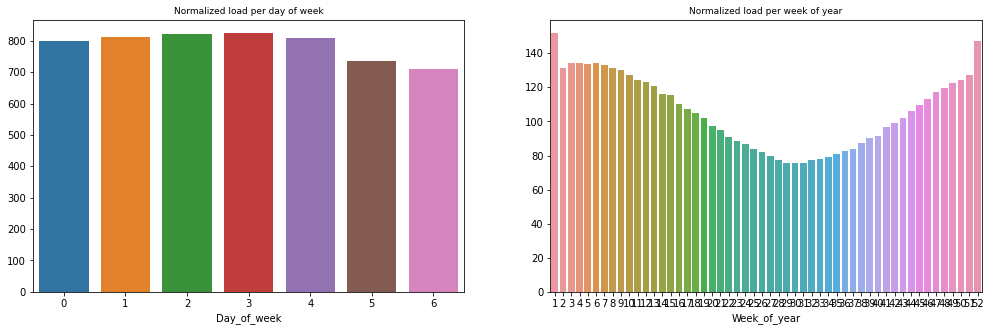

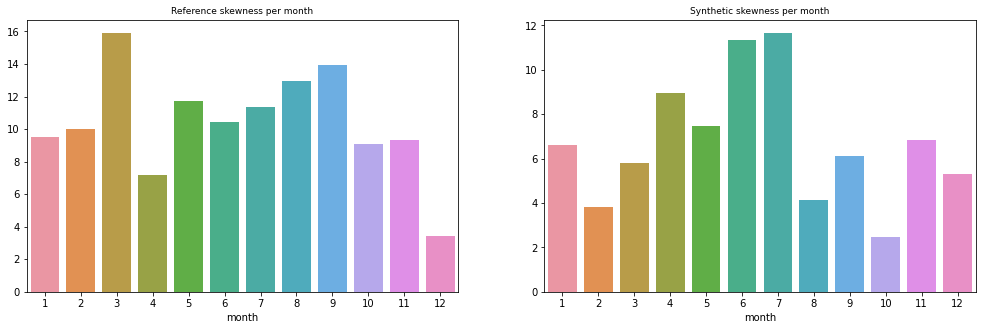

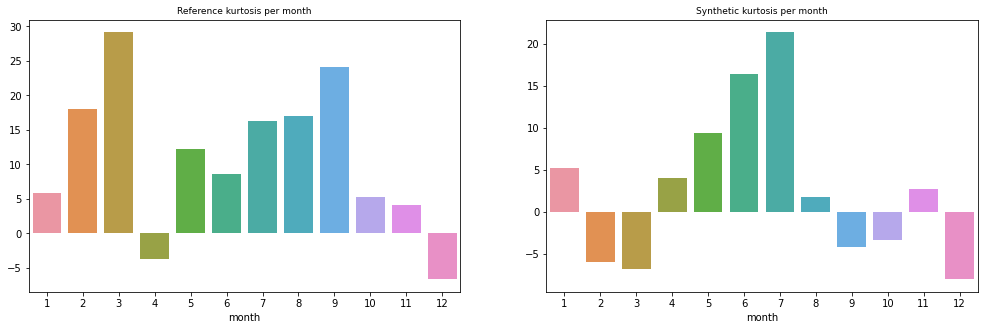

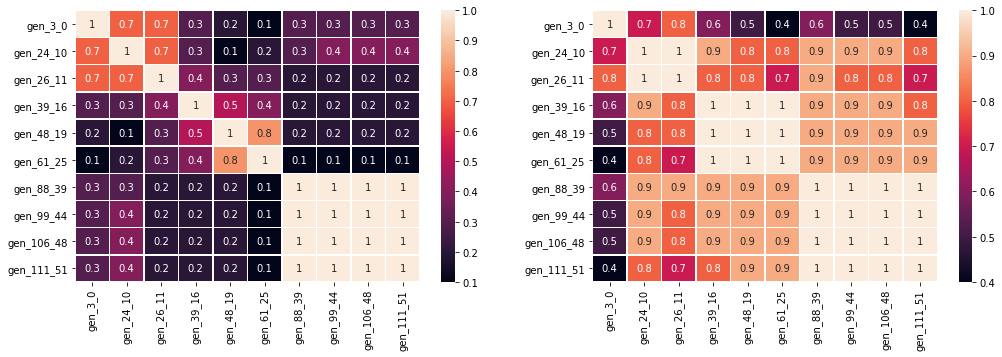

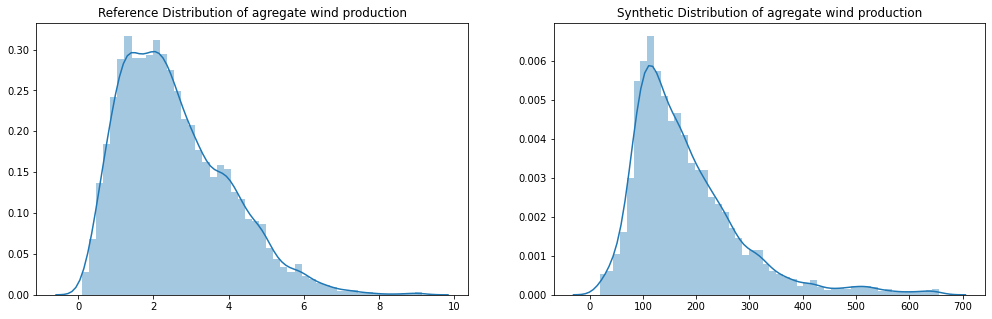

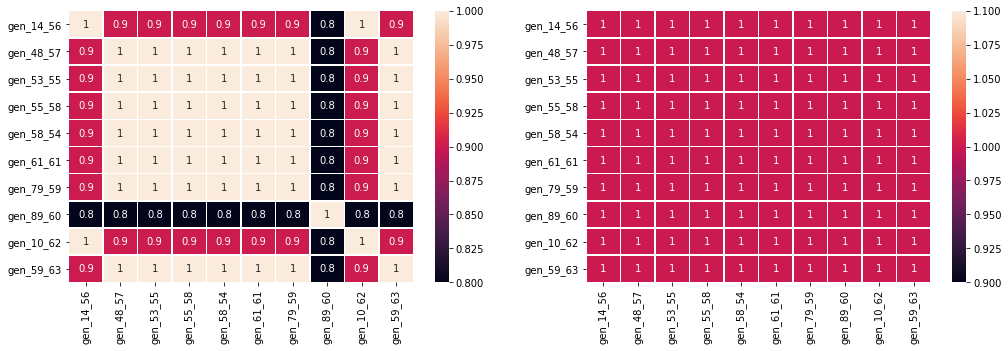

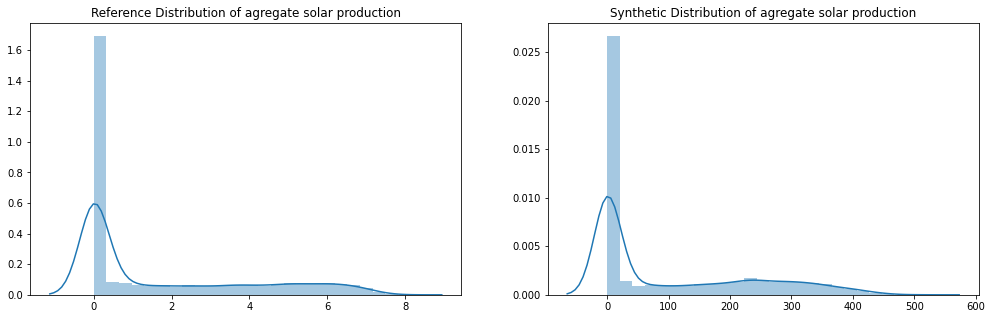

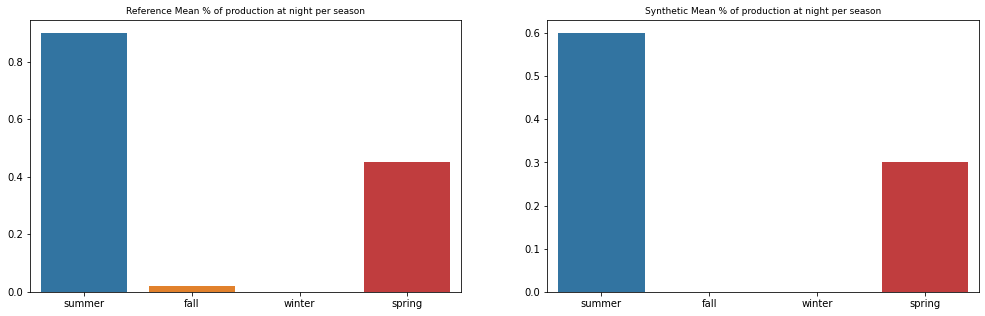

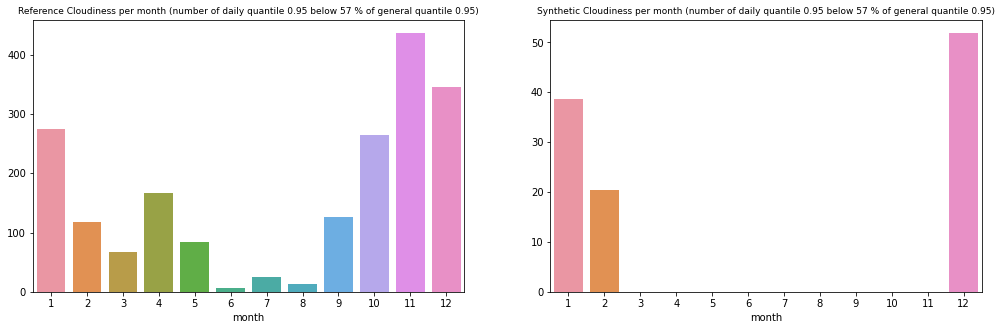

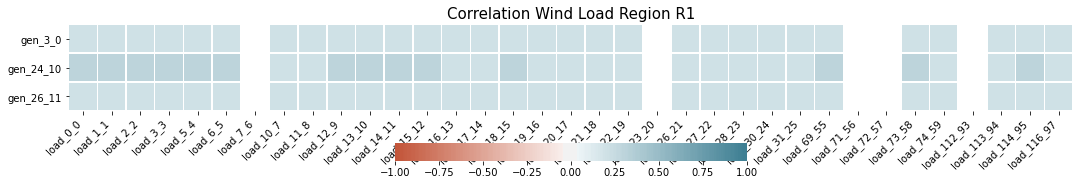

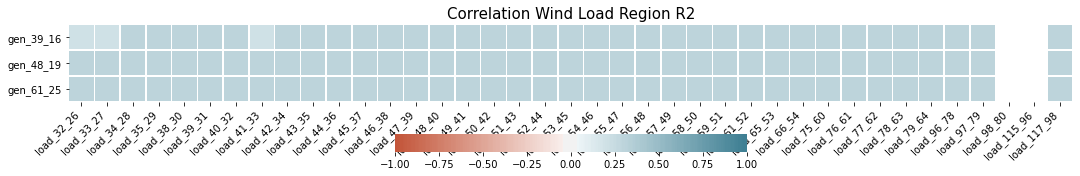

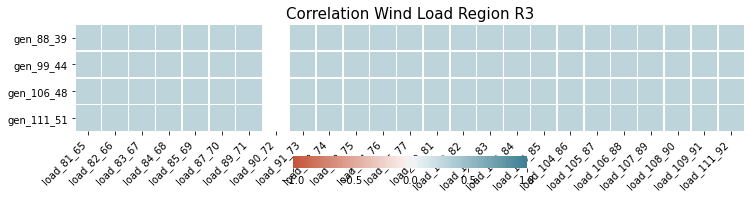

In [16]:
wind_solar_only = True
if not os.path.exists(KPI_INPUT_FOLDER):
    os.mkdir(KPI_INPUT_FOLDER)
kpis.main(KPI_INPUT_FOLDER, INPUT_FOLDER, OUTPUT_FOLDER, IMAGES_FOLDER, year, CASE, n_scenarios, wind_solar_only, params)

## Create The EconomicDispatch instance : a high level wrapper around a Pypsa net

To install PyPSA correctly <br>
`pip3 install -U git+http://github.com/PyPSA/PyPSA.git@8d527e25fa9876cac66957448f449a1c901901d2`

You also need to install the solver that pypsa is calling. For instance cbc solver. On Fedora do `dnf install coin-or-Cbc.x86_64`

In [17]:
%load_ext autoreload
%autoreload 2
import generation.dispatch.EconomicDispatch as ec
import generation.thermal.EDispatch_L2RPN2020.run_economic_dispatch as run_economic_dispatch

In [18]:
dispatch = ec.Dispatch.from_gri2op_env(env118_withoutchron)
dispatch.modify_marginal_costs({'hydro': 3, 'nuclear': 8})
dispatch.read_hydro_guide_curves(os.path.join(INPUT_FOLDER, 'patterns', 'hydro.csv'))

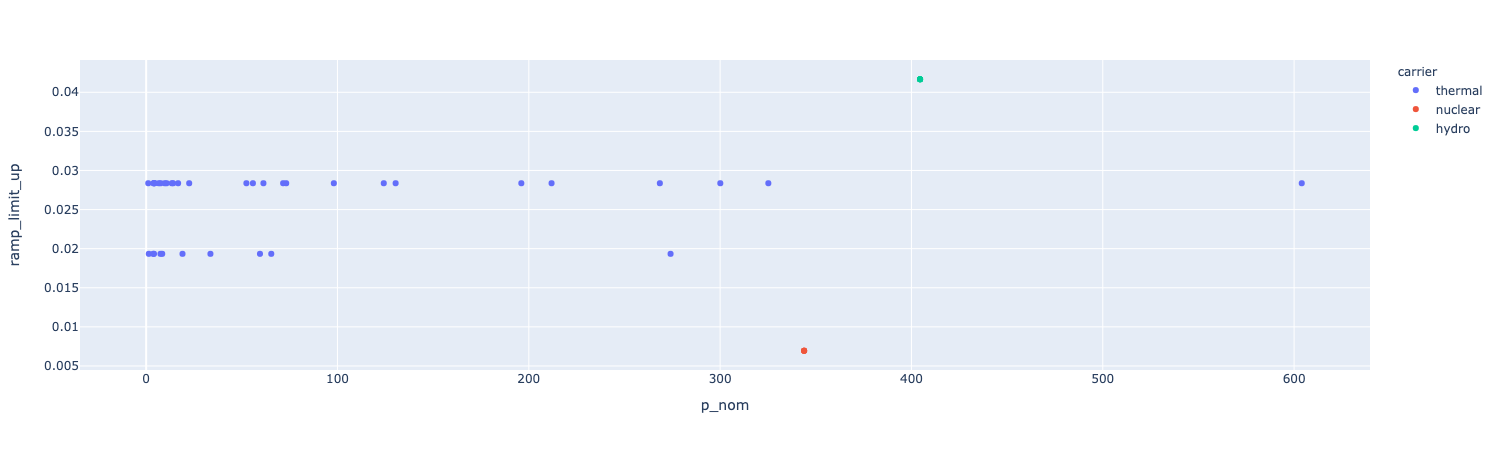

In [19]:
dispatch.plot_ramps()

## II B) Run a unit commitment model

we will use pypsa. To avoid messing with the names, and make sure to have data in the proper shape, it is better, I think, to create the pypsa network directly from the grid2op environment.

For more information on unit commitment see https://pypsa.org/examples/unit-commitment.html for example.

### Run opf

In [20]:
#20min time computation for a year with every generators at monthly resolution --- Fail on month of june
#8min time computation for a year with every generators at weekly resolution --- Fail for last 2 weeks of june
#10.5min time computation for a year with every generators at daily resolution --- Fail for 17 and 24 of june 
#=>no thermal on those days, probably due to ramps! But was converging when looking only per carrier type

#1min time computation for a year with every carrier at monthly resolution --- Fail on month of june
#6min time computation for a year with every carrier at daily resolution --- Fail on month of june
params = {'step_opf_min': 5,
          'mode_opf': 'month',
          'reactive_comp': 1.025,
}

In [21]:
dts = pd.DataFrame(index=pd.date_range(start='2012-01-01 00:00', periods=105408, freq='5min'))
dts.loc['2012-02-29'].shape

(288, 0)

In [22]:
french_hydro = pd.read_csv('generation/input/patterns/hydro_french_pattern.csv', usecols=[0,1,2,3,4])
french_hydro.set_index('datetime', inplace=True)
french_hydro.tail(3)

,gen_11_4,gen_17_6,gen_53_20,gen_58_23
datetime,,,,
2007-12-31 23:45:00,0.142753,0.142753,0.142753,0.142753
2007-12-31 23:50:00,0.131311,0.131311,0.131311,0.131311
2007-12-31 23:55:00,0.120000,0.120000,0.120000,0.120000


In [24]:
cols = french_hydro.columns

In [25]:
full_hydro = pd.concat([french_hydro.loc['2007-01-01':'2007-02-29'].reset_index(drop=True),
                        pd.DataFrame(np.nan, index=np.arange(dts.loc['2012-02-29'].shape[0]), columns=cols),
                        french_hydro.loc['2007-03-01':'2008-01-01'].reset_index(drop=True)], axis=0, ignore_index=True)
full_hydro.shape

(105408, 4)

In [26]:
full_hydro.index = dts.index
full_hydro.head(3)

,gen_11_4,gen_17_6,gen_53_20,gen_58_23
2012-01-01 00:00:00,0.249654,0.249654,0.249654,0.249654
2012-01-01 00:05:00,0.287726,0.287726,0.287726,0.287726
2012-01-01 00:10:00,0.320142,0.320142,0.320142,0.320142


In [27]:
# Interpolate feb 29
full_hydro.interpolate(method='quadratic', axis=0, inplace=True)

In [28]:
hydro_constraints = {}
hydro_constraints['p_max_pu'] = full_hydro.copy()
hydro_constraints['p_min_pu'] = pd.DataFrame(0, index=full_hydro.index, columns=full_hydro.columns)

In [1]:
hydro_constraints

NameError: name 'hydro_constraints' is not defined

In [29]:
losses_pct = 3.0
DispatchByCarrierOnly=False
parent_folder_path = os.path.join(OUTPUT_FOLDER, str(year))

# Rigth now if you want to rerun this you'll probably have to re-instanciate the Dispatch class

# The run is by scenario
for subpath in os.listdir(chronics_path_gen):
    
    if subpath in ['.DS_Store']:
        continue
    
    this_path = os.path.join(chronics_path_gen, subpath)
    dispatch.read_load_and_res_scenario(os.path.join(this_path, 'load_p.csv.bz2'),
                                        os.path.join(this_path, 'prod_p.csv.bz2'),
                                        scenario_name=subpath)
    dispatch.make_hydro_constraints_from_res_load_scenario()
    agg_load_without_renew = dispatch.net_load(losses_pct, name=dispatch.loads.index[0])
    
    # Example of how to extract info on the largest ramps
    print(f'5 largest ramps reached by the agg_load_without_renew:')
    print(dispatch.nlargest_ramps(5, losses_pct))
    
    # Prepare gen constraints for EDispatch module
#     hydro_constraints = {'p_max_pu': dispatch._max_hydro_pu.copy(), 'p_min_pu': dispatch._min_hydro_pu.copy()}
    
#     print (hydro_constraints['p_min_pu'].shape)
    
    # Run Economic Disptach using submodule EDisptach_L2RPN_2020
    # **  **  **  **  **  **  **  **  **  **  **  **  **  **
    chronix_scenario, term_conditions = dispatch.run(
                                        agg_load_without_renew,
                                        params=params,
                                        gen_constraints=hydro_constraints,
                                        ramp_mode=run_economic_dispatch.RampMode.none,
                                        by_carrier=DispatchByCarrierOnly  # True to run the dispatch only aggregated generators by carrier
                                    )
    # save prods chronics
    dispatch.save_results(parent_folder_path)

5 largest ramps reached by the agg_load_without_renew:
                           
datetime                   
2012-04-02 12:15:00  84.408
2012-06-01 09:35:00  79.007
2012-02-07 11:15:00  76.692
2012-09-16 12:15:00  76.486
2012-09-16 12:10:00  76.158
Preprocessing input data..
Filter generators ramps up/down
Adapting PyPSA grid with parameters..

--> OPF formulation by => month - Analyzing month # 1


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 2.8s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 7.46e+08
INFO:pypsa.linopf:Prepare linear problem


-- opf succeeded  >Objective value (should be greater than zero!

--> OPF formulation by => month - Analyzing month # 2


INFO:pypsa.linopf:Total preparation time: 2.09s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 5.47e+08
INFO:pypsa.linopf:Prepare linear problem


-- opf succeeded  >Objective value (should be greater than zero!

--> OPF formulation by => month - Analyzing month # 3


INFO:pypsa.linopf:Total preparation time: 2.31s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 5.66e+08
INFO:pypsa.linopf:Prepare linear problem


-- opf succeeded  >Objective value (should be greater than zero!

--> OPF formulation by => month - Analyzing month # 4


INFO:pypsa.linopf:Total preparation time: 2.22s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 5.09e+08
INFO:pypsa.linopf:Prepare linear problem


-- opf succeeded  >Objective value (should be greater than zero!

--> OPF formulation by => month - Analyzing month # 5


INFO:pypsa.linopf:Total preparation time: 2.31s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 3.12e+08
INFO:pypsa.linopf:Prepare linear problem


-- opf succeeded  >Objective value (should be greater than zero!

--> OPF formulation by => month - Analyzing month # 6


INFO:pypsa.linopf:Total preparation time: 2.85s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 1.46e+08
INFO:pypsa.linopf:Prepare linear problem


-- opf succeeded  >Objective value (should be greater than zero!

--> OPF formulation by => month - Analyzing month # 7


INFO:pypsa.linopf:Total preparation time: 2.36s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 1.40e+08
INFO:pypsa.linopf:Prepare linear problem


-- opf succeeded  >Objective value (should be greater than zero!

--> OPF formulation by => month - Analyzing month # 8


INFO:pypsa.linopf:Total preparation time: 2.34s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 2.03e+08
INFO:pypsa.linopf:Prepare linear problem


-- opf succeeded  >Objective value (should be greater than zero!

--> OPF formulation by => month - Analyzing month # 9


INFO:pypsa.linopf:Total preparation time: 2.28s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 2.92e+08
INFO:pypsa.linopf:Prepare linear problem


-- opf succeeded  >Objective value (should be greater than zero!

--> OPF formulation by => month - Analyzing month # 10


INFO:pypsa.linopf:Total preparation time: 2.28s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 4.41e+08
INFO:pypsa.linopf:Prepare linear problem


-- opf succeeded  >Objective value (should be greater than zero!

--> OPF formulation by => month - Analyzing month # 11


INFO:pypsa.linopf:Total preparation time: 2.17s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 5.40e+08
INFO:pypsa.linopf:Prepare linear problem


-- opf succeeded  >Objective value (should be greater than zero!

--> OPF formulation by => month - Analyzing month # 12


INFO:pypsa.linopf:Total preparation time: 2.26s
INFO:pypsa.linopf:Solve linear problem using Cbc solver
INFO:pypsa.linopf:Optimization successful. Objective value: 6.76e+08


-- opf succeeded  >Objective value (should be greater than zero!
Total time 1.39 min
OPF Done......


chronix_scenario is an object containing all the time series related to the studied scenario : 
- chronix_scenario.name gives the name of the scenario
- chronix_scenario.wind_p (resp. solar_p, prods_dispatch, loads) gives the Wind DataFrame (resp. Solar, Dispatched generators, loads)

This object should be manipulated in the sequel.

In [30]:
#check that the max net load is similar than after generating loads and renewables
agg_load_without_renew.max()

agg_load    3831.471
dtype: float64

In [31]:
# Concatenate renewable dispatch

#Becareful:check years of opf_dispatch and dispatch
print(chronix_scenario.wind_p.index[0])
print(chronix_scenario.prods_dispatch.index[0])

2012-01-01 00:00:00
2007-01-01 00:00:00


In [32]:
if(chronix_scenario.wind_p.index[0] != chronix_scenario.prods_dispatch.index[0]):
    chronix_scenario.prods_dispatch.index=chronix_scenario.wind_p.index
if DispatchByCarrierOnly:
    chronix_scenario.prods_dispatch=chronix_scenario.prods_dispatch[['nuclear','hydro','thermal']]#makesure nuclear comesfirst, for good plotting after

full_opf_dispatch = pd.concat(
    [chronix_scenario.prods_dispatch, chronix_scenario.wind_p, chronix_scenario.solar_p],
    axis=1
)

# Keep same order as grid2op
if not DispatchByCarrierOnly:
    full_opf_dispatch = full_opf_dispatch[env118_withoutchron.name_gen].round(2)

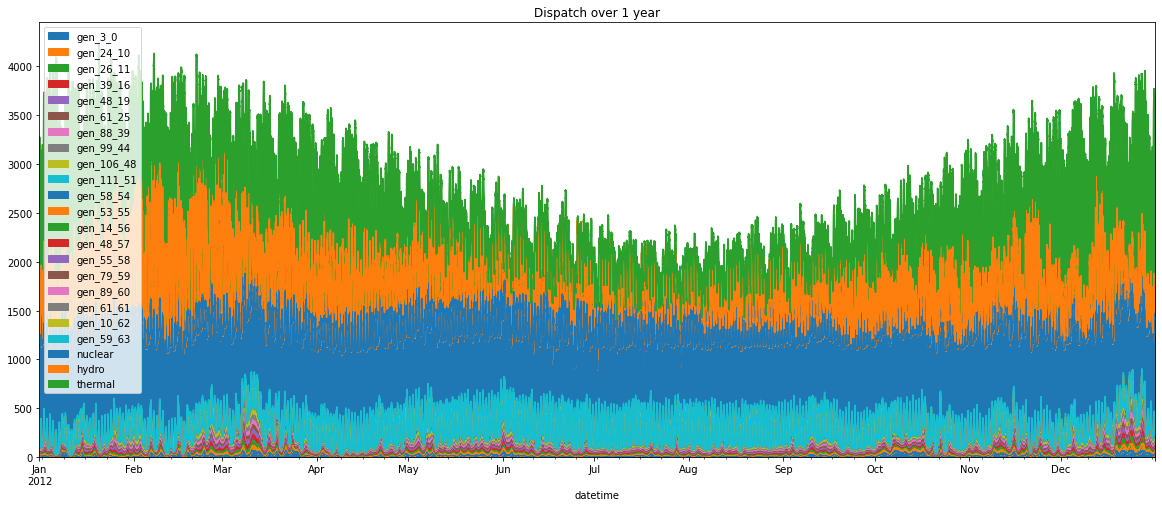

In [33]:
if not DispatchByCarrierOnly:
    nuclear_names = dispatch.generators[dispatch.generators.carrier == 'nuclear'].index
    hydro_names = dispatch.generators[dispatch.generators.carrier == 'hydro'].index
    thermal_names = dispatch.generators[dispatch.generators.carrier == 'thermal'].index

    dispatch_by_fleet=pd.concat([ dispatch.wind_p, dispatch.solar_p], axis=1)
    dispatch_by_fleet['nuclear'] = full_opf_dispatch[nuclear_names].sum(axis=1).to_frame('Nuclear')
    dispatch_by_fleet['hydro'] = full_opf_dispatch[hydro_names].sum(axis=1)
    dispatch_by_fleet['thermal'] = full_opf_dispatch[thermal_names].sum(axis=1)
    #dispatch_by_fleet=pd.concat([dispatch_by_fleet, dispatch.wind_p, dispatch.solar_p], axis=1)

    dispatch_by_fleet.loc[dispatch_by_fleet['thermal'] < 0, 'thermal'] = 0

    # grid2op env starts in 2007 but read loads are in 2012...
    #dispatch_by_fleet = dispatch_by_fleet.loc[dispatch_by_fleet.index.year == 2007,:]

    dispatch_by_fleet.plot(figsize=(20, 8), title='Dispatch over 1 year', kind='area')

else:
    dispatch_by_fleet=full_opf_dispatch
    
    dispatch_by_fleet.loc[dispatch_by_fleet['thermal'] < 0, 'thermal'] = 0 #due to numeric approximation,some thermal values  could be negative
    dispatch_by_fleet.loc[dispatch_by_fleet['hydro'] < 0, 'hydro'] = 0
    #full_opf_dispatch[full_opf_dispatch['thermal']<0]['thermal'].hist()
    dispatch_by_fleet.plot(figsize=(20, 8), title='Dispatch over 1 year', kind='area')


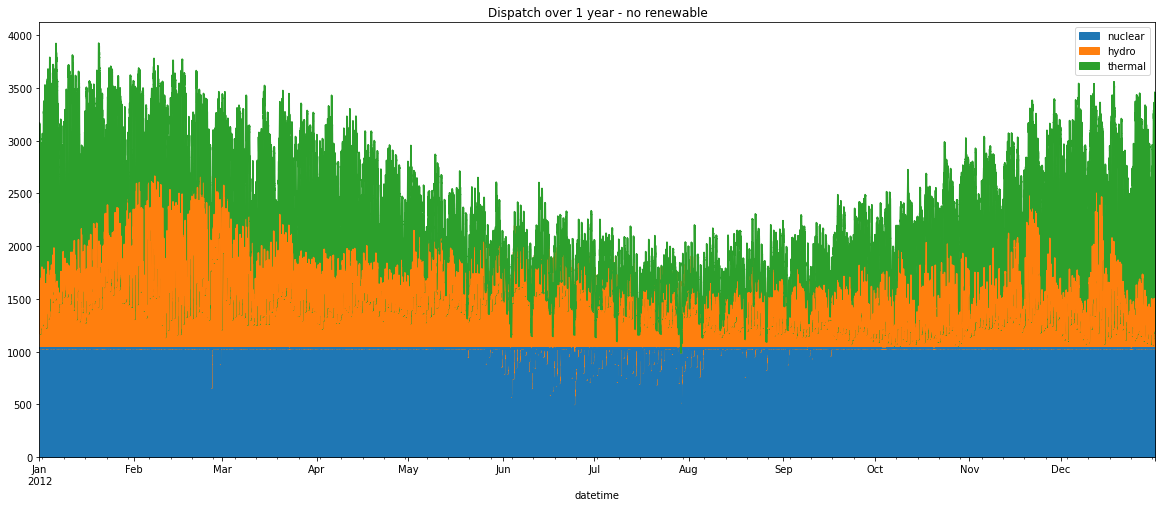

In [34]:
dispatch_by_fleet[['nuclear','hydro','thermal']].plot(figsize=(20, 8), title='Dispatch over 1 year - no renewable', kind='area')

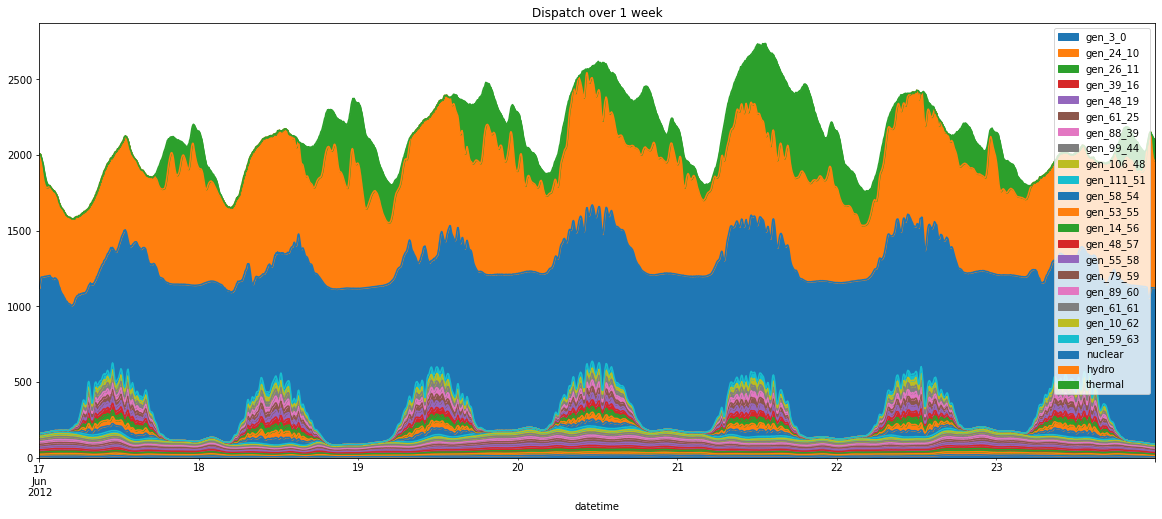

In [35]:
WeekNumber=24
dispatch_by_fleet.iloc[(288*7*WeekNumber):(288*7*(WeekNumber+1)), :].plot(figsize=(20, 8), title='Dispatch over 1 week', kind='area')

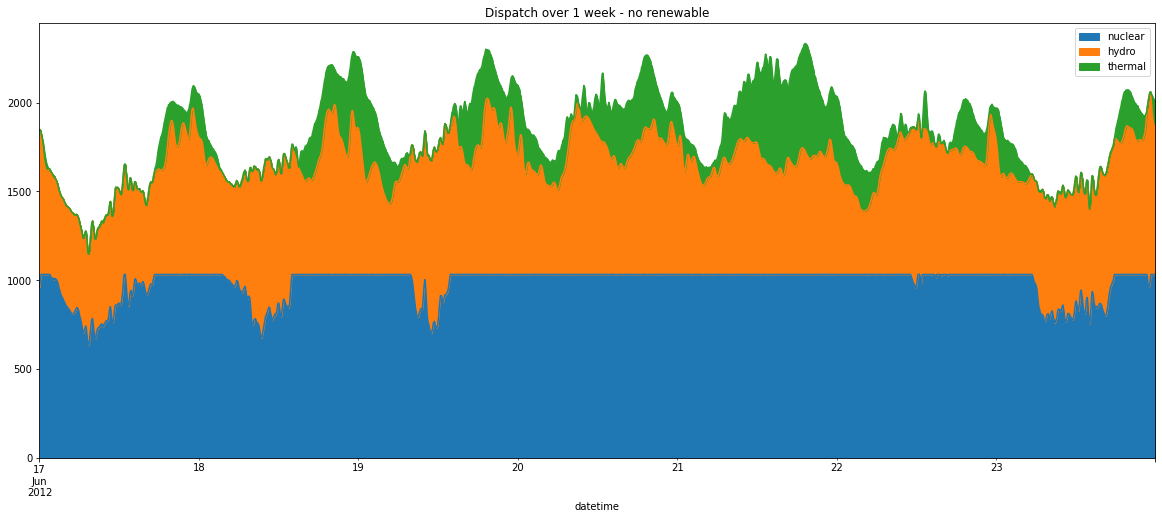

In [36]:
dispatch_by_fleet[['nuclear','hydro','thermal']].iloc[(288*7*WeekNumber):(288*7*(WeekNumber+1)), :].plot(figsize=(20, 8), title='Dispatch over 1 week - no renewable', kind='area')

Check Hydro 

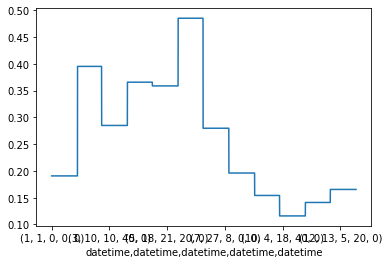

In [37]:
#In june, Hydro might be high and the minimum hydro production to respect forces nuclear to decrease its production
minHydroPattern=dispatch._min_hydro_pu
nCols=minHydroPattern.shape[1]
minHydroPattern.iloc[:,0].plot()

In [38]:
# Validate whether they have same order
np.all(full_opf_dispatch.columns == env118_withoutchron.name_gen)

True

### Compute some KPIs for dispatch
As I never had a dispatch output file, I didn't have a precise output format for the dispatch to be taken into account by the KPI module.So I chose to take the format of the only example i had: chronics exported by a previous script of Camilo with month by month dispatch chronics. 
- Download these files to have a format example on Nextcloud: https://nextcloud.artelys.com/nextcloud/s/tFirA3TRXrHeFwC
- Careful, this example is for year 2007
- We should agree on an output format from dispatch. Maybe you could put it on Nextcloud as an example for me

#### You have to set "eco2mix" as comparison in KPI_INPUT_FOLDER/paramsKPI.json
**Images were not designed to be plot on a notebook but to be saved as png or zoomable in IMAGES_FOLDER**. In particular, yearly productions and energy mix are better to watch in their written files

In [ ]:
%%capture

wind_solar_only = False
if not os.path.exists(KPI_INPUT_FOLDER):
    os.mkdir(KPI_INPUT_FOLDER)
kpis.main(KPI_INPUT_FOLDER, INPUT_FOLDER, OUTPUT_FOLDER, IMAGES_FOLDER, year, CASE, n_scenarios, wind_solar_only, params)

# III Create an environment with the chronics this time

This is to test the environment can be used by grid2op. This is what the "case118_l2rpn" will look like for the competitions.

**NB** The "Balthazar code" is fully compatible with the "GridStateFromFileWithForecasts". So it is useful to use this class to load back the data. If the data generation process does not provide the same utilities, it is not a problem to write another class, like "GridStateFromFileWithForecasts" that can read its format.

### Correct the bug in element 7_4_173

In [ ]:
# Chose generated scenario
scenario = 'Scenario_0'

In [ ]:
# line = pd.DataFrame(columns=env118_withoutchron.name_line.tolist())
# line.to_csv('/Users/camiloromero/Rte/EDispatch_L2RPN2020/lines_names.txt', sep=';', index=False)

In [ ]:
scenario_path = os.path.join(OUTPUT_FOLDER, str(year), scenario)
hazard = pd.read_csv(os.path.join(scenario_path, 'hazards.csv.bz2'), sep=';')
chronics_line_names = hazard.columns.tolist()

lines_names = {}
for g, c in zip(env118_withoutchron.name_line, chronics_line_names):
    lines_names[c] = g
    
names_chronics_to_backend = {}
names_chronics_to_backend['lines'] = lines_names

** I can't run from the following cell: can't make the dispatch run on my machine and don't data in the right format**

In [ ]:
from grid2op.ChronicsHandler import Multifolder, GridStateFromFileWithForecasts
from grid2op.Parameters import Parameters
# don't disconnect powerline on overflow, the thermal limit are not set for now, it would not make sens
param = Parameters()
param.init_from_dict({"NO_OVERFLOW_DISCONNECTION": True})

#chronics_path_gen = os.path.join(chronics_path, "chronics")
chronics_path_gen = None

env = grid2op.make("blank",  # to generate a blank environment
                   grid_path=os.path.join(path_grid, "L2RPN_2020_case118_redesigned.json"), # assign it the 118 grid
                   chronics_class=Multifolder, # tell it to change nothing (not the most usable environment...)
                   data_feeding_kwargs= {"path": chronics_path_gen, "gridvalueClass": GridStateFromFileWithForecasts},
                   param=param,
                   names_chronics_to_backend = names_chronics_to_backend,
                  )

And now we can test that we can use a Runner, store the results, and plot the flows on the powerline for example

# IV Validate the generation process

For that we use a runner, that will compute the powerflows with a "do nothing" agent, and we prevent it to disconnect any power line, even if they are on overflow.

In [ ]:
from grid2op.Runner import Runner
path_data_saved = chronics_path+"_computed"
runner = Runner(**env.get_params_for_runner())

# here you might need to change "nb_episode" if you generated more than one scenario
# this might really take some times... 4 mins per scenario per week [on one core]
res = runner.run(nb_episode=nb_episode, path_save=path_data_saved, pbar=True)

Then we can study the results, for example by loading the chronics, extracting prod p, load p etc.

In [ ]:
from grid2op.Utils import ActionSpace, ObservationSpace
import numpy as np
from tqdm.notebook import tqdm

path_data_saved_ep0 = os.path.join(path_data_saved, "0")
action_space = ActionSpace.from_dict(os.path.join(path_data_saved, "dict_action_space.json"))
env_modif_space = ActionSpace.from_dict(os.path.join(path_data_saved, "dict_env_modification_space.json"))
observation_space = ObservationSpace.from_dict(os.path.join(path_data_saved, "dict_observation_space.json"))
observations_npy = np.load(os.path.join(path_data_saved_ep0, "observations.npy"))
li_observations = []
for i in range(observations_npy.shape[0]):
    tmp = observation_space.from_vect(observations_npy[i,:])
    li_observations.append(tmp)

In [ ]:
flows_a = np.array([obs.a_or for obs in li_observations])
loads_p = np.array([obs.load_p for obs in li_observations])
prods_p = np.array([obs.prod_p for obs in li_observations])

display distribution of flows over scenarios

In [ ]:
import matplotlib.pyplot as plt
flow_a_vector=np.concatenate(flows_a, axis=None)
plt.hist(flow_a_vector,bins=200)

Computes the KPI you want with that...

In [ ]:
# TODO

Go back to **II)** if results are not satisfying.

# V Export the final results

First, regenerate a lot more data, then save then

In [ ]:
# TODO generate more data with the same distribution as the one that has been validated

In [ ]:
# TODO export them to be usable in a friendly manner